# YouTube Channel Analysis - 1M65 Channel

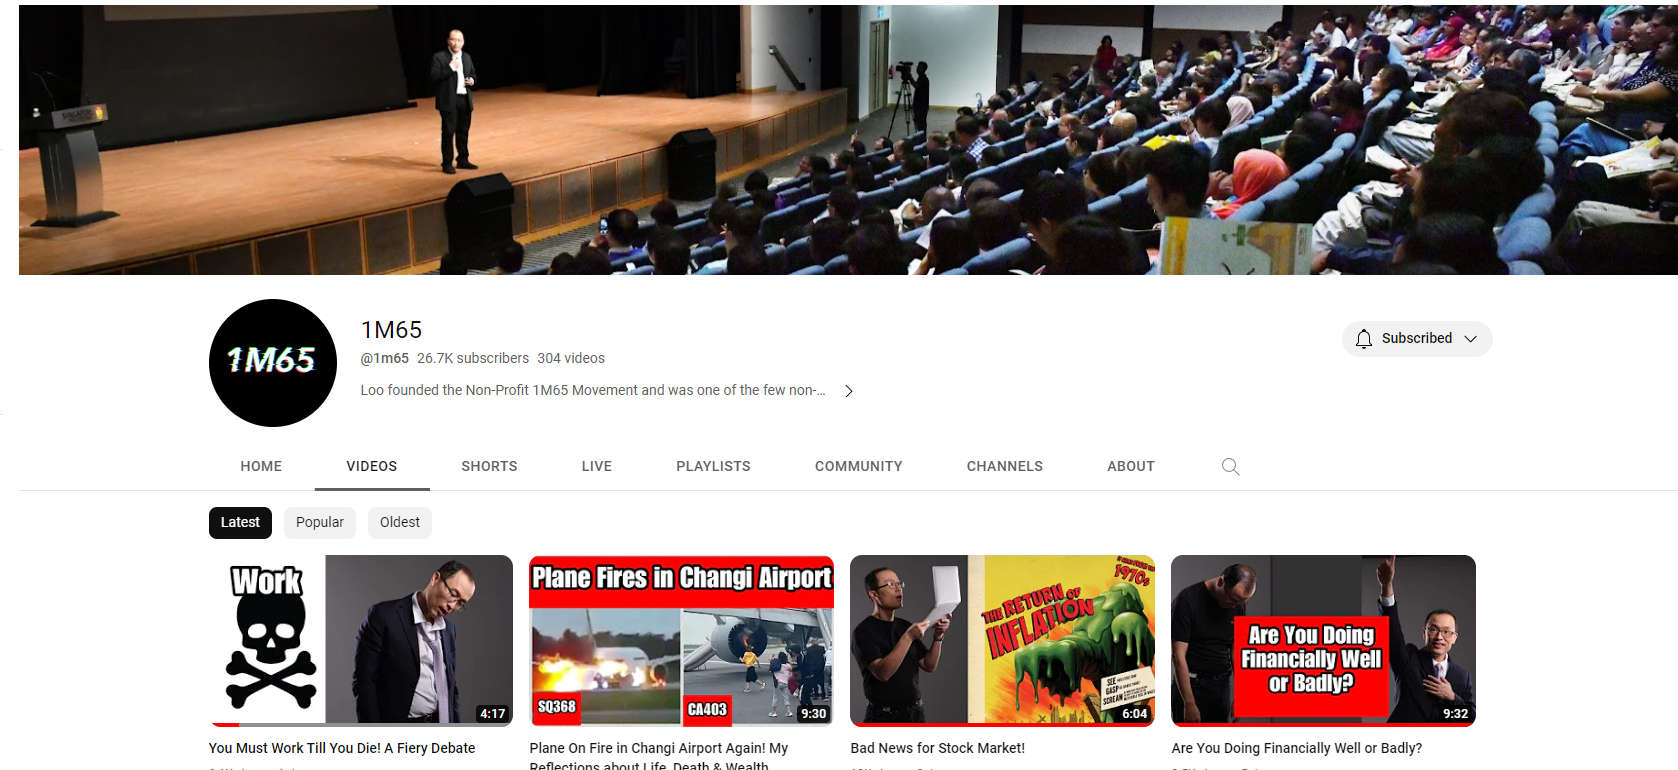

In [34]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
nltk.download('stopwords')
# nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\irvin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# get api key from Google Developers Console: https://developers.google.com/youtube/v3/getting-started

api_key = 'your-api-key-here'

In [4]:
channel_ids = ['UCd273tHeZ_v8miEED5MZasQ',
               # input more channel ids here if you wish to
              ]

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=','.join(channel_ids)
)
response = request.execute()

# print(response)

JSON(response)


<IPython.core.display.JSON object>

In [102]:
# define get_channel_stats function
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    """
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs if more than 1
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    """    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    #loop through items in response
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)


In [7]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [8]:
channel_stats

channelName subscribers    views totalVideos                playlistId
0        1M65       26700  4048686         304  UUd273tHeZ_v8miEED5MZasQ

In [9]:
# Assign value to playlist_id variable
playlist_id = 'UUd273tHeZ_v8miEED5MZasQ'

In [10]:
request = youtube.playlistItems().list(
    part="snippet,contentDetails",
    playlistId=playlist_id
)
response = request.execute()

JSON(response)

<IPython.core.display.JSON object>

In [11]:
# define get_video_ids function
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [12]:
# define video_ids variable
video_ids = get_video_ids(youtube, playlist_id)

In [13]:
len(video_ids)

305

In [14]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [15]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

video_id channelTitle  \
0    Qxw3O83Fn0s         1M65   
1    qbc-kv8q-_Y         1M65   
2    X0tuR8JA8i4         1M65   
3    b8TpWqLlevU         1M65   
4    S4fzLzo7BmI         1M65   
..           ...          ...   
300  jipck7hI2Bw         1M65   
301  Y0oiVRd-vJs         1M65   
302  Agup0ynuHyw         1M65   
303  8ca9GLx-2xo         1M65   
304  U7zCpoHImBk         1M65   

                                                 title  \
0          You Must Work Till You Die!  A Fiery Debate   
1    Plane On Fire in Changi Airport Again! My Refl...   
2                           Bad News for Stock Market!   
3             Are You Doing Financially Well or Badly?   
4    HDB Price Hike Worsen, Govt's Response Too Lit...   
..                                                 ...   
300         Should We Chase the Property Bull Run Now?   
301     Why is there a Property Bull Run in Singapore?   
302                                Is 1M65 Bullsh*t???   
303        What I've done to teach my kids about Money   
304  10 Reasons Why the Stock Market Bull Run will ...   

                                           description  \
0                                                        
1                                                        
2                                                        
3    I know many of you don’t like to be compared a...   
4                                                        
..                                                 ...   
300  A part 2 to the first video about what we thin...   
301  Despite the COVID affected economy, the Singap...   
302  In a recent article published by Asiaone on 1M...   
303  Parenting isn't easy and we get that, especial...   
304  The US stock market is experiencing a dramatic...   

                                                  tags           publishedAt  \
0    [Business, Work, Career, Retirement, Finances,...  2023-09-12T10:58:57Z   
1    [Insurance, Will, Lasting power of attorney, W...  2023-09-11T14:48:46Z   
2    [Inflation, Stock market, Investment, Oil pric...  2023-09-10T12:33:57Z   
3    [Investment, Wealth, Net worth, Stock, Stocks,...  2023-09-08T12:27:57Z   
4    [Housing, HDB, Property, Condominium, Condo, I...  2023-09-07T13:07:32Z   
..                                                 ...                   ...   
300  65, loo cheng chuan, kate loo, singapore, p...  2020-11-18T12:30:11Z   
301  65, loo cheng chuan, kate loo, property, si...  2020-11-02T11:30:13Z   
302  65, campaign, party, finance, financial too...  2020-09-27T13:30:01Z   
303  [money, children, finance, young parents, less...  2020-07-12T14:00:13Z   
304  [stock market, donald trump, federal reserve, ...  2020-06-22T12:00:10Z   

    viewCount likeCount favouriteCount commentCount  duration definition  \
0        5934       178           None           39   PT4M17S         hd   
1        6605       258           None           19   PT9M30S         hd   
2       12296       530           None           30    PT6M4S         hd   
3        8545       270           None           37   PT9M32S         hd   
4        9667       322           None          104   PT10M9S         hd   
..        ...       ...            ...          ...       ...        ...   
300      7012       266           None           15  PT17M14S         hd   
301      9723      None           None           29  PT16M11S         hd   
302     11158       183           None           27  PT13M35S         hd   
303     13159       342           None           21  PT19M28S         hd   
304      6940       194           None           19  PT19M44S         sd   

    caption  
0     false  
1     false  
2     false  
3     false  
4     false  
..      ...  
300   false  
301   false  
302   false  
303   false  
304   false  

[305 rows x 13 columns]

## Data Pre-processing

In [16]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [17]:
video_df[video_df['likeCount'].isnull()]

video_id channelTitle                                           title  \
301  Y0oiVRd-vJs         1M65  Why is there a Property Bull Run in Singapore?   

                                           description  \
301  Despite the COVID affected economy, the Singap...   

                                                  tags           publishedAt  \
301  65, loo cheng chuan, kate loo, property, si...  2020-11-02T11:30:13Z   

    viewCount likeCount favouriteCount commentCount  duration definition  \
301      9723      None           None           29  PT16M11S         hd   

    caption  
301   false

In [31]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [18]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [19]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [24]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
# video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')
video_df['durationSecs'] = video_df['durationSecs'].dt.total_seconds()

In [25]:
video_df['durationSecs'].dtypes

dtype('float64')

In [26]:
video_df[['durationSecs', 'duration']]

durationSecs  duration
0           257.0   PT4M17S
1           570.0   PT9M30S
2           364.0    PT6M4S
3           572.0   PT9M32S
4           609.0   PT10M9S
..            ...       ...
300        1034.0  PT17M14S
301         971.0  PT16M11S
302         815.0  PT13M35S
303        1168.0  PT19M28S
304        1184.0  PT19M44S

[305 rows x 2 columns]

In [27]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [28]:
# View updated df
video_df

video_id channelTitle  \
0    Qxw3O83Fn0s         1M65   
1    qbc-kv8q-_Y         1M65   
2    X0tuR8JA8i4         1M65   
3    b8TpWqLlevU         1M65   
4    S4fzLzo7BmI         1M65   
..           ...          ...   
300  jipck7hI2Bw         1M65   
301  Y0oiVRd-vJs         1M65   
302  Agup0ynuHyw         1M65   
303  8ca9GLx-2xo         1M65   
304  U7zCpoHImBk         1M65   

                                                 title  \
0          You Must Work Till You Die!  A Fiery Debate   
1    Plane On Fire in Changi Airport Again! My Refl...   
2                           Bad News for Stock Market!   
3             Are You Doing Financially Well or Badly?   
4    HDB Price Hike Worsen, Govt's Response Too Lit...   
..                                                 ...   
300         Should We Chase the Property Bull Run Now?   
301     Why is there a Property Bull Run in Singapore?   
302                                Is 1M65 Bullsh*t???   
303        What I've done to teach my kids about Money   
304  10 Reasons Why the Stock Market Bull Run will ...   

                                           description  \
0                                                        
1                                                        
2                                                        
3    I know many of you don’t like to be compared a...   
4                                                        
..                                                 ...   
300  A part 2 to the first video about what we thin...   
301  Despite the COVID affected economy, the Singap...   
302  In a recent article published by Asiaone on 1M...   
303  Parenting isn't easy and we get that, especial...   
304  The US stock market is experiencing a dramatic...   

                                                  tags  \
0    [Business, Work, Career, Retirement, Finances,...   
1    [Insurance, Will, Lasting power of attorney, W...   
2    [Inflation, Stock market, Investment, Oil pric...   
3    [Investment, Wealth, Net worth, Stock, Stocks,...   
4    [Housing, HDB, Property, Condominium, Condo, I...   
..                                                 ...   
300  65, loo cheng chuan, kate loo, singapore, p...   
301  65, loo cheng chuan, kate loo, property, si...   
302  65, campaign, party, finance, financial too...   
303  [money, children, finance, young parents, less...   
304  [stock market, donald trump, federal reserve, ...   

                  publishedAt  viewCount  likeCount  favouriteCount  \
0   2023-09-12 10:58:57+00:00     5934.0      178.0             NaN   
1   2023-09-11 14:48:46+00:00     6605.0      258.0             NaN   
2   2023-09-10 12:33:57+00:00    12296.0      530.0             NaN   
3   2023-09-08 12:27:57+00:00     8545.0      270.0             NaN   
4   2023-09-07 13:07:32+00:00     9667.0      322.0             NaN   
..                        ...        ...        ...             ...   
300 2020-11-18 12:30:11+00:00     7012.0      266.0             NaN   
301 2020-11-02 11:30:13+00:00     9723.0        NaN             NaN   
302 2020-09-27 13:30:01+00:00    11158.0      183.0             NaN   
303 2020-07-12 14:00:13+00:00    13159.0      342.0             NaN   
304 2020-06-22 12:00:10+00:00     6940.0      194.0             NaN   

     commentCount  duration definition caption pushblishDayName  durationSecs  \
0            39.0   PT4M17S         hd   false          Tuesday         257.0   
1            19.0   PT9M30S         hd   false           Monday         570.0   
2            30.0    PT6M4S         hd   false           Sunday         364.0   
3            37.0   PT9M32S         hd   false           Friday         572.0   
4           104.0   PT10M9S         hd   false         Thursday         609.0   
..            ...       ...        ...     ...              ...           ...   
300          15.0  PT17M14S         hd   false        Wednesday        1034.0   
301          29.0  PT16M11S 

# EDA

## Best Performing Videos

C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


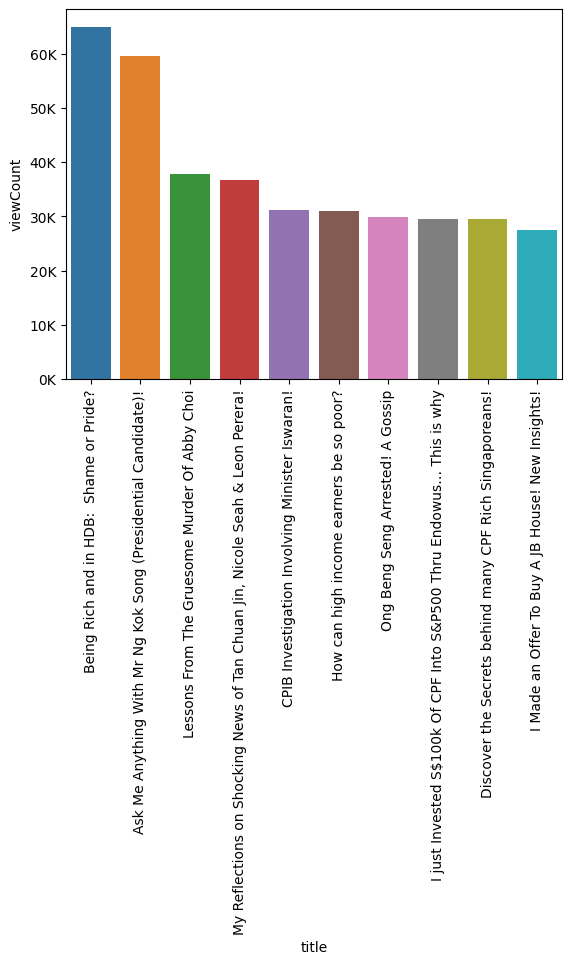

In [55]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Comments:

Interestingly, the best performing videos were not those about CPF or personal finance. Instead, 3 out of the top 5 video titles involved SG politics, with the number 1 video centred around something what Mr Loo is "famous" or known for which is being financially secure but not living in an upper class residential housing. 

The top video titled *"Being Rich and in HDB: Shame or Pride?"* garnered more than 60,000 views.

The video with the 3rd most views at close to 60,000 views was on the topic of the gruesome murder of Abby Choi, a non-local incident that happened in Hong Kong. From the level of interest, we can see that this murder case shooked the whole community not only in Hong Kong itself but possibly the region or internationally. 


## Worst Performing Videos

C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


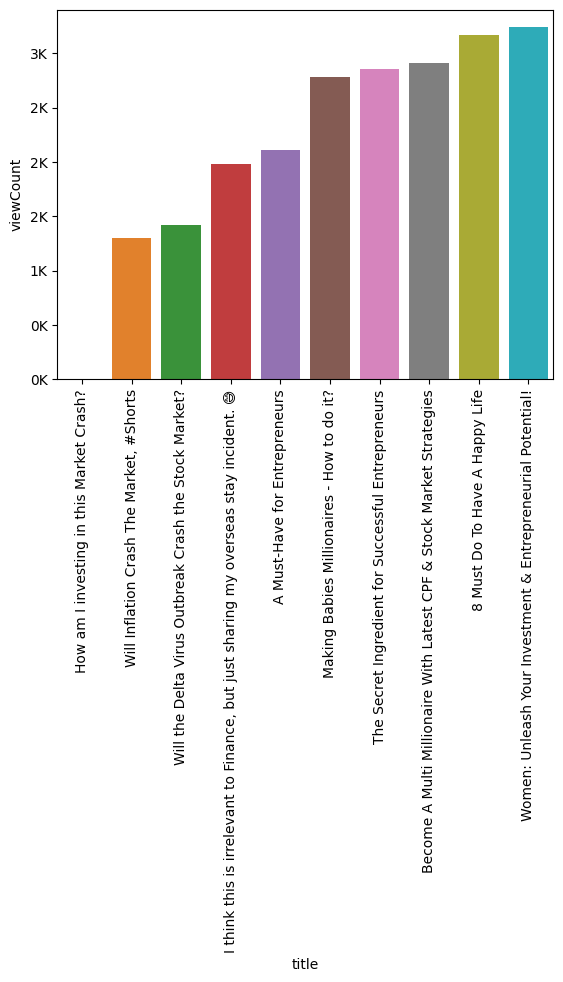

In [57]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Comments:

In finding out the worst performing videos, I observed that the 10 worst videos were mostly hovering between 1000+ to 3000+ views. I also noticed the worst performing video returned was one that had totally no views and it is titled *"How am I investing in this Market Crash?"*.

Upon further inspection and returning the particular record, that video had 0 tags, 0 viewCount, 0 likeCount and had no duration. I then did a manual search on the 1M65 videos page with the title and could not find such a video. Without knowing further detail on the intricacies of the YouTube platform, I can probably infer that this video was a YouTube live video that was later not published as a permanent video in his channel or that this video might have been listed as a private video. More information would be needed if I wanted to be 100% certain.

In [54]:
video_df[video_df['title'] == 'How am I investing in this Market Crash?']

video_id channelTitle                                     title  \
237  EErCCu7Pr2k         1M65  How am I investing in this Market Crash?   

              description  tags               publishedAt  viewCount  \
237  Going live now .....  None 2022-05-08 08:43:36+00:00        0.0   

     likeCount  favouriteCount  commentCount duration definition caption  \
237        0.0             NaN           0.0      P0D         sd   false   

    pushblishDayName  durationSecs  tagCount  
237           Sunday           0.0         0

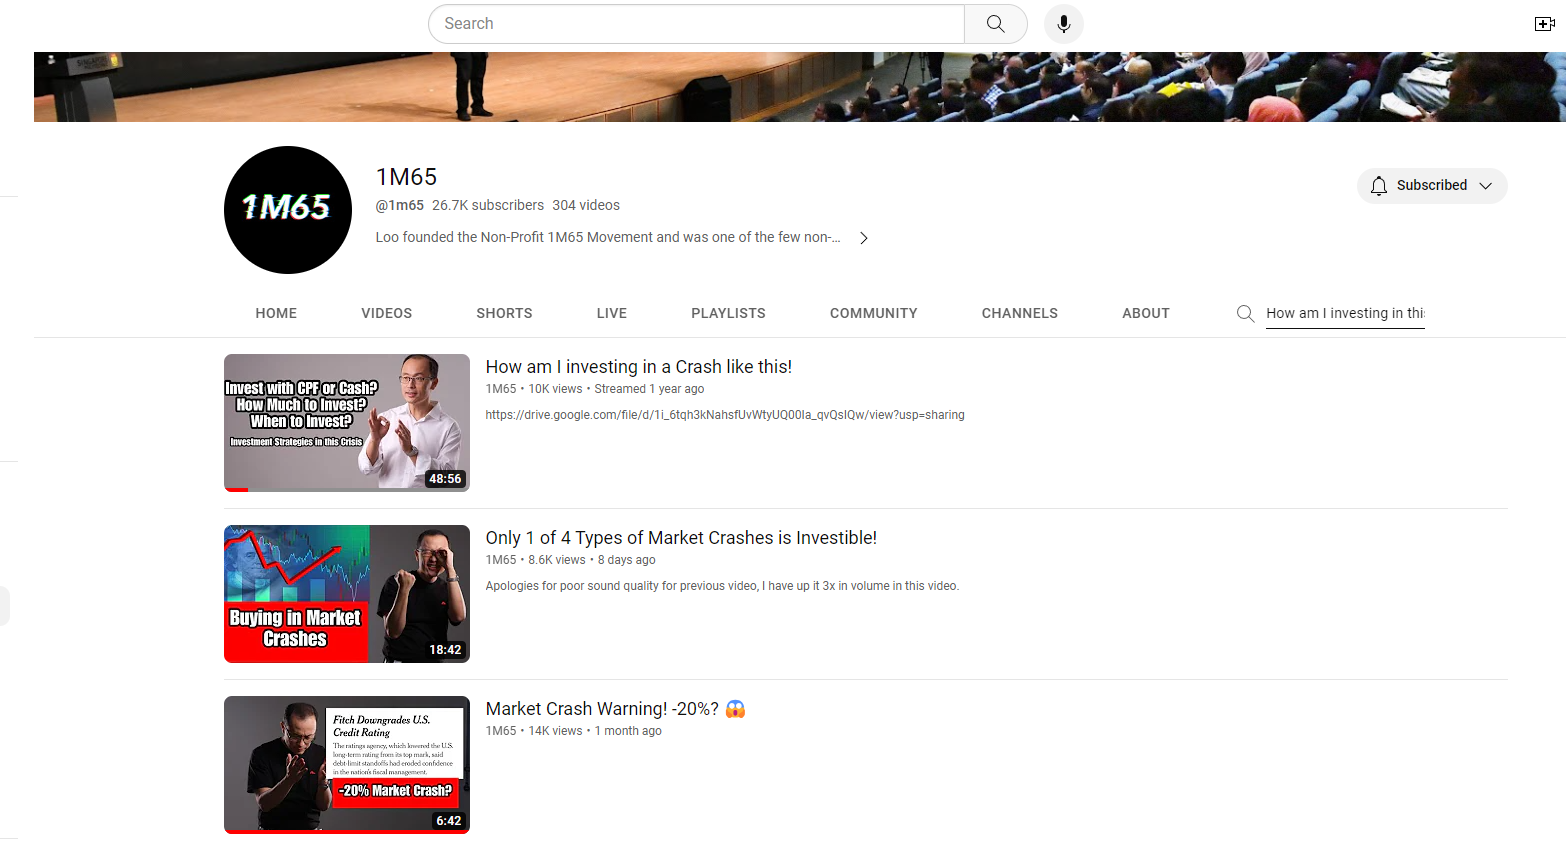

In [53]:
video_df[video_df['title'] == '8 Must Do To Have A Happy Life']

video_id channelTitle                           title  \
287  5hIevLCB_K4         1M65  8 Must Do To Have A Happy Life   

                                           description  tags  \
287  Everyone wants to be happy, but not everyone k...  None   

                  publishedAt  viewCount  likeCount  favouriteCount  \
287 2021-09-15 10:00:05+00:00     3166.0       51.0             NaN   

     commentCount duration definition caption pushblishDayName  durationSecs  \
287           0.0  PT1M15S         hd   false        Wednesday          75.0   

     tagCount  
287         0

## View Distribution Per Video

C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='channelTitle', ylabel='viewCount'>

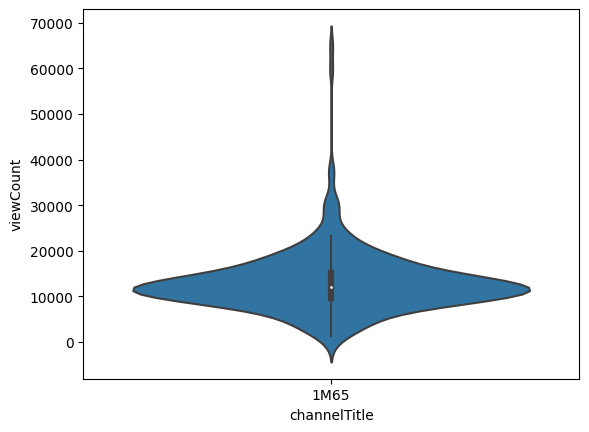

In [61]:
sns.violinplot(x=video_df['channelTitle'], y=video_df['viewCount'])

## Comments:

Here, we can see that the video viewCount range from close to 0 all the way to around 70,000 views. 

The majority of videos have between 10,000 to 15,000 views and the median is somewhere in the middle of that range. 

## Views vs. Likes and Comments

C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='likeCount', ylabel='viewCount'>

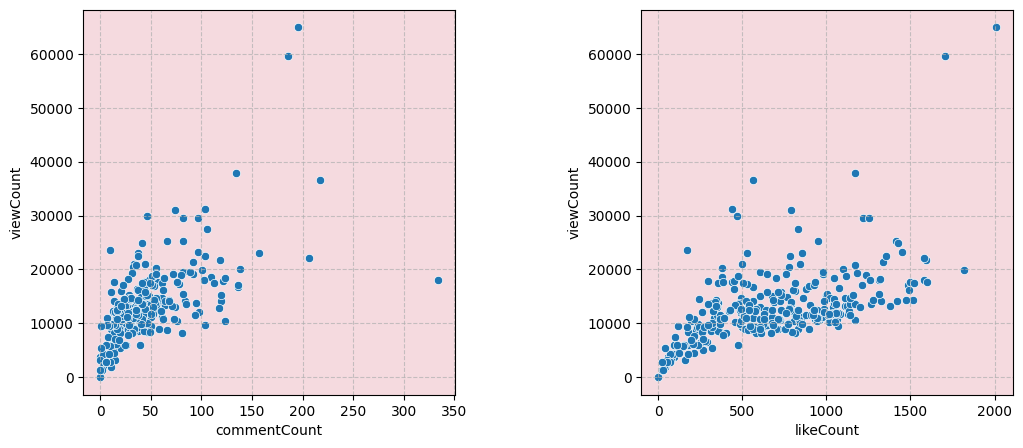

In [71]:
# Create a wider figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

# Add some horizontal space between the subplots
plt.subplots_adjust(wspace=0.5)  # Adjust the wspace as needed

for axis in ax:
    axis.set_facecolor('#F5DADF') 
    axis.grid(True, linestyle='--', alpha=0.7)

sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

### Comments:

We can see a stronger positive correlation for viewCount and likeCount, there is a more consistent trend where a higher viewCount would generally correspond to a higher likeCount. 

It is slightly less so when it comes to viewCount vs commentCount. We can see that there are a number of instances whereby a similar or lower viewCount video had a proportionally higher number of commentCount. This could be due to certain video topics having a smaller number of viewers but being able to better engage them in commenting due to them having more talking points.

## Video Duration

C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


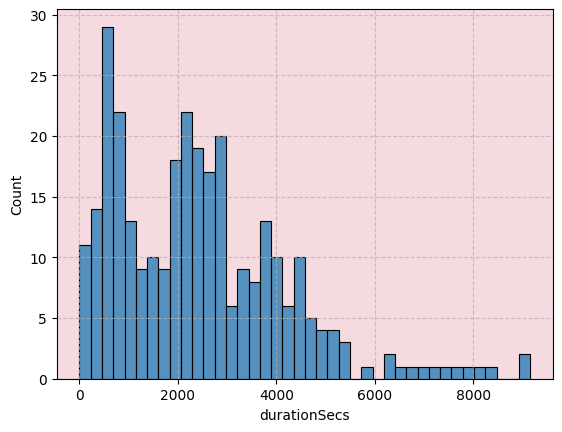

In [90]:
ax = sns.histplot(data=video_df, x='durationSecs', bins=40)

ax.set_facecolor('#F5DADF')  # Set the background color (light gray)
ax.grid(True, linestyle='--', alpha=0.7)


## Wordcloud for Video Titles

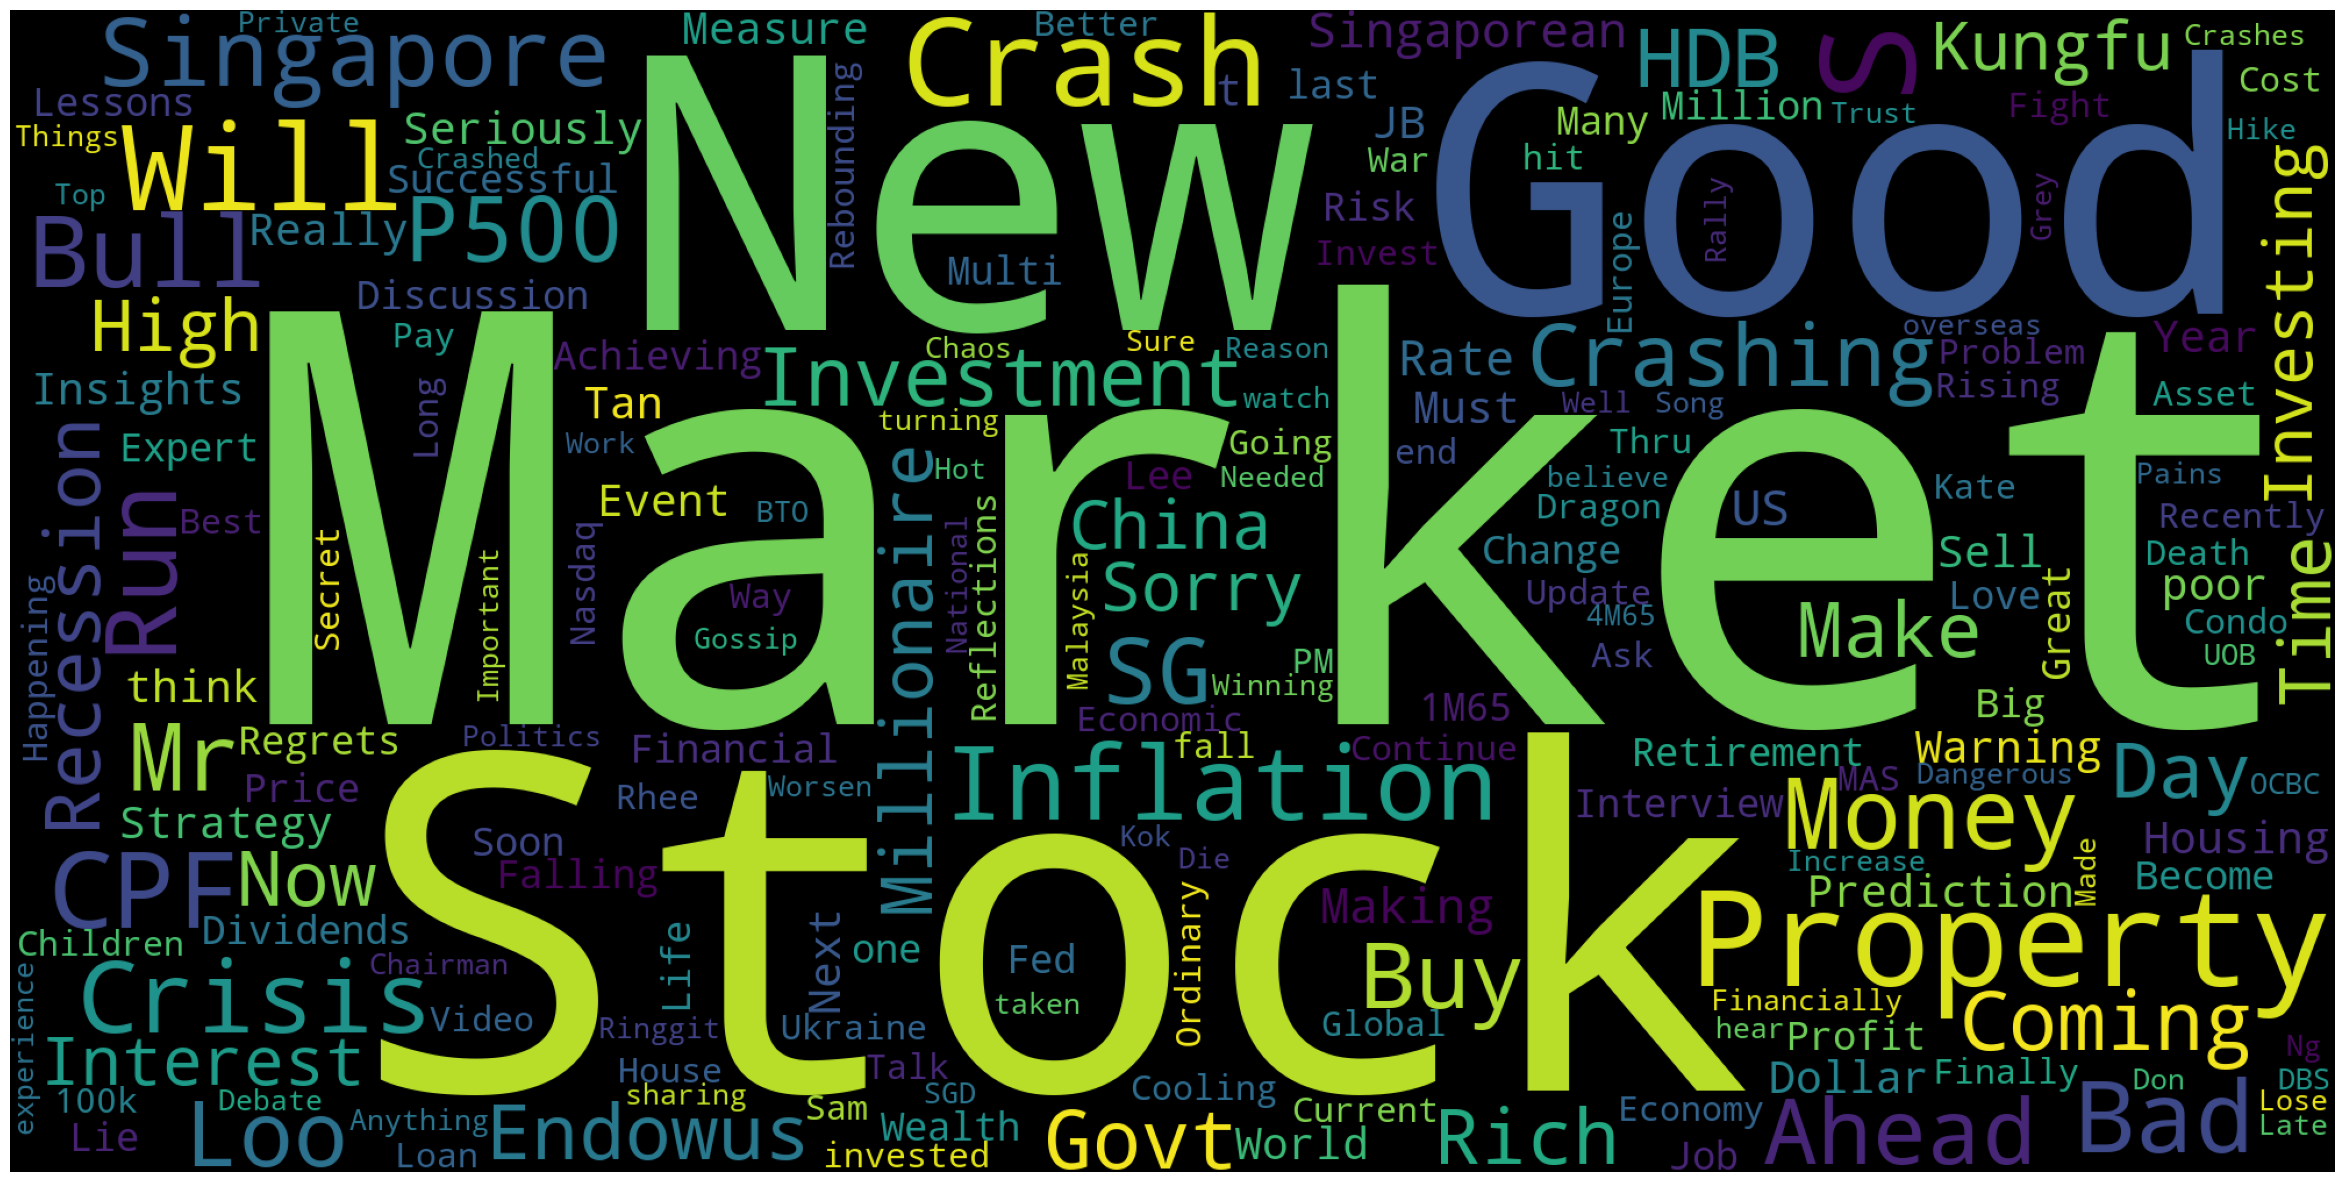

In [94]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

## Upload schedule

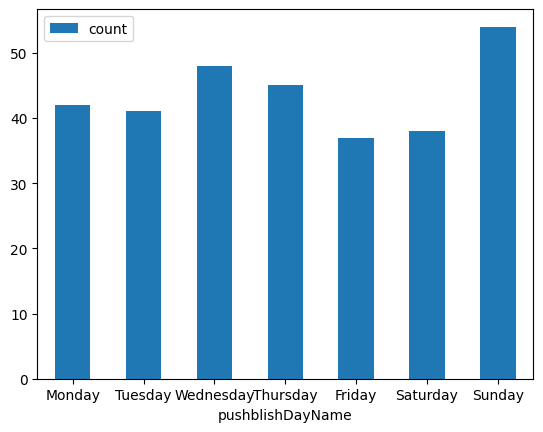

In [99]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set 'weekday' column as the index
day_df.index = day_df.index.astype(pd.CategoricalDtype(categories=weekdays, ordered=True))

# Sort the index to ensure the correct order on the plot
day_df = day_df.sort_index()

# Plot the bar chart
ax = day_df.plot.bar(rot=0)
plt.show()